In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [16]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

#         (0, 1),
#         (1, 2),
        
#         (2, 1),
#         (2, 3),
        
#         (3, 2),
#         (3, 0),

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
        # (3, 4),
        # (4, 3)
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


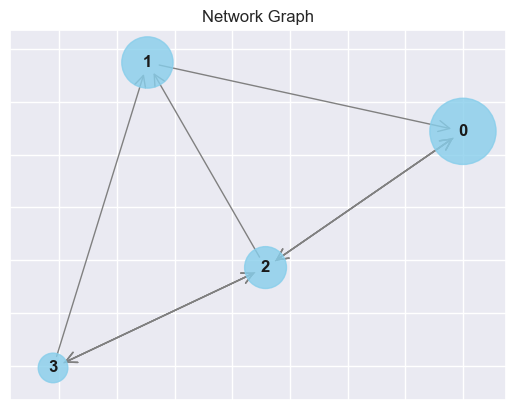

In [17]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Marius\anaconda3\envs\phd-env\lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


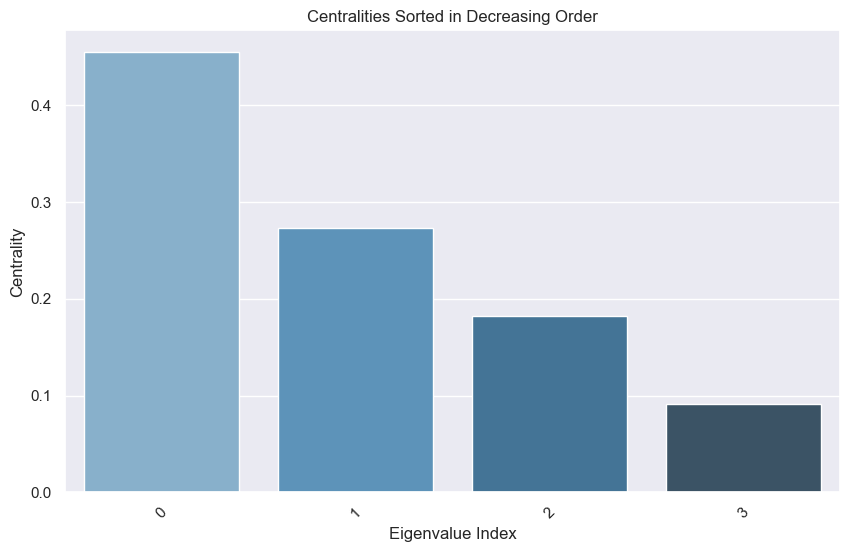

In [18]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5204647904080085
Final Error: 0.5120701748735514


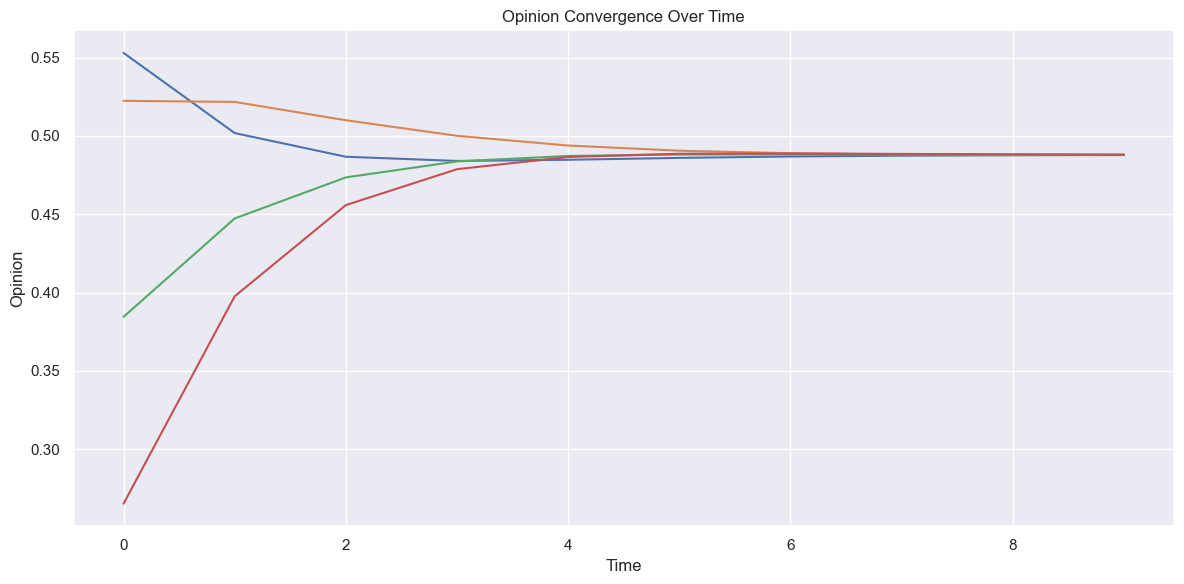

In [19]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4404062183365226
Final Error: 0.4096100799532245


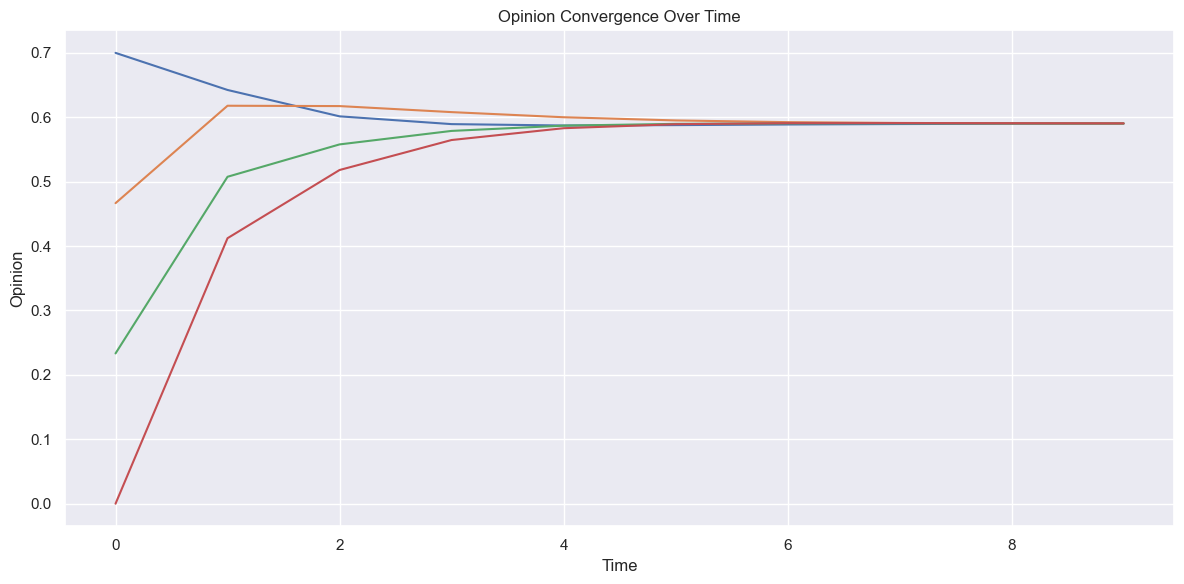

In [20]:
env = init_env()
num_steps = 10  # Total number of steps in the simulation
Q = 4  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Correct DP

DPMULT step 1
Optimal Budget Allocation (BETA): [2 2]
Final Cost: 0.3889476584022037


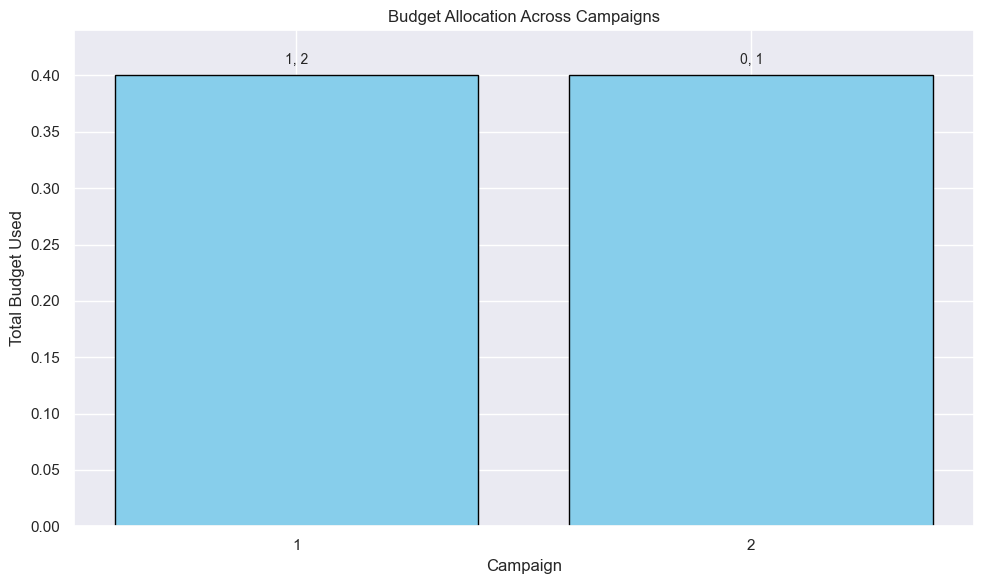

In [21]:
# Initialize environment
env = init_env()

# Parameters
M = 2  # Number of campaigns
TB = 4  # Total budget
ubar = env.max_u

# Run dynamic programming
V, B, order, order0 = dynamic_programming_multiplicative(env, M, TB)

# Forward propagation to compute optimal budget allocation and final cost
BETA, U, X, final_cost = forward_propagation_multiplicative(env, V, B, order, order0, M, TB)

# Print results
print("Optimal Budget Allocation (BETA):", BETA)
print("Final Cost:", final_cost)

plot_campaign_budgets_with_order(BETA, order, order0, ubar)

Dynamic Programming Strategy - Overall Error: 0.42578485812860684
Final Error: 0.3889476629653308
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


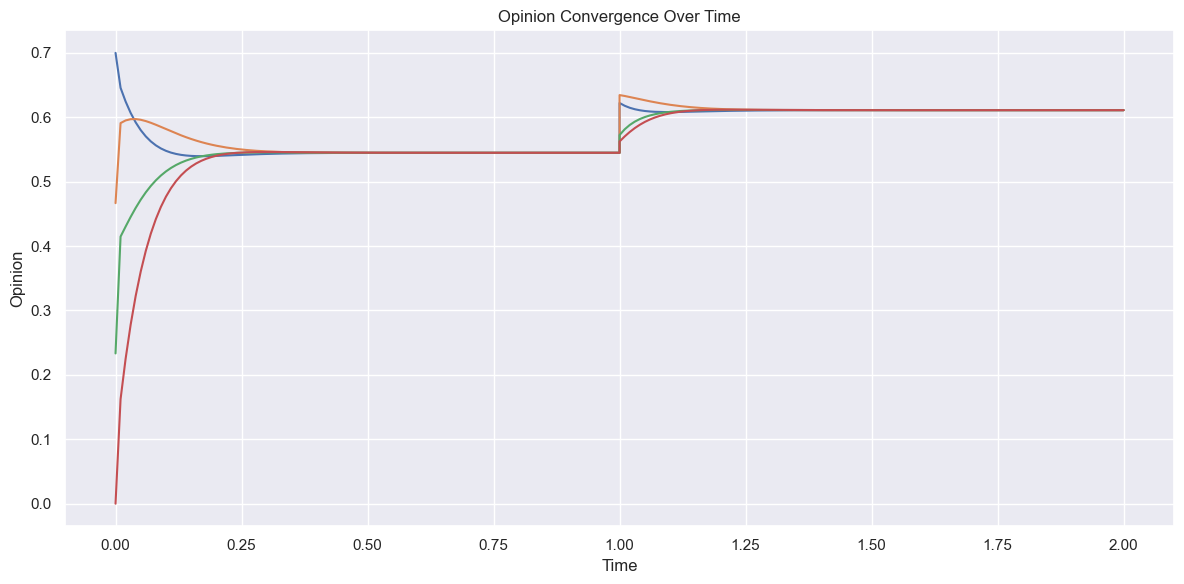

In [22]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Fine DP

In [53]:
import numpy as np
from itertools import product
from copy import deepcopy

def create_state_grid(N, nx):
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def compute_new_states(current_states, control_input, env):
    # Adjusted for influence dynamics among agents
    xd = env.desired_opinion
    eigv = env.centralities
    influence_matrix = np.outer(eigv, eigv)  # Simulating adjacency with centrality influence
    state_influence = influence_matrix @ current_states  # Neighbor influence propagation
    
    # Weighted combination of influenced state and direct control
    new_states = (1 - eigv) * state_influence + eigv * (control_input * xd + (1 - control_input) * current_states)
    return new_states

def dynamic_programming_high_dim(env, M, TB, nx=10, gamma=1):
    env = deepcopy(env)
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion
    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)
    
    V = np.full((M + 1,) + grid_shape + (TB + 1,), np.inf)
    B_dict = {}

    grid_points = np.array(np.meshgrid(*grids, indexing='ij')).T.reshape(-1, N)
    terminal_cost = ((grid_points - xd) ** 2).mean(axis=1).reshape(grid_shape)
    
    V[M, ..., :] = np.repeat(terminal_cost[..., np.newaxis], TB + 1, axis=-1)

    for k in range(M - 1, -1, -1):
        print(f"\nDP step {k}")
        for rem in range(TB + 1):
            for idx in np.ndindex(grid_shape):
                current_states = np.array([grids[i][idx[i]] for i in range(N)])
                val = np.inf
                best_control = None

                for beta_used in range(0, min(rem, N) + 1):
                    if rem - beta_used < 0:
                        continue

                    for control_vector in product([0, 1], repeat=N):
                        if sum(control_vector) != beta_used:
                            continue

                        control_input = np.array(control_vector) * ubar
                        new_states = compute_new_states(current_states, control_input, env)
                        new_states_clipped = np.clip(new_states, 0, 1)

                        next_idx = tuple(np.searchsorted(grids[i], new_states_clipped[i]) - 1 for i in range(N))
                        next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))
                        future_cost = V[k + 1][next_idx + (rem - beta_used,)]

                        immediate_cost = ((new_states_clipped - xd) ** 2).mean()
                        total_cost = immediate_cost + gamma * future_cost

                        if total_cost < val:
                            val = total_cost
                            best_control = control_input

                if best_control is not None:
                    V[(k,) + idx + (rem,)] = val
                    B_dict[(k,) + idx + (rem,)] = best_control

    return V, B_dict

def forward_propagation_high_dim(env, V, B_dict, M, TB, nx=10):
    env = deepcopy(env)
    N = env.num_agents
    grids = create_state_grid(N, nx)
    X = np.zeros((N, M + 1))
    U = np.zeros((N, M))
    BETA_hd = np.zeros(M, dtype=int)
    X[:, 0] = env.opinions.copy()
    rem = TB
    xd = env.desired_opinion

    total_cost = 0

    for k in range(M):
        current_states = X[:, k]
        idx = tuple(np.searchsorted(grids[i], current_states[i]) - 1 for i in range(N))
        idx = tuple(np.clip(idx[i], 0, nx - 1) for i in range(N))

        key = (k,) + idx + (rem,)
        control_input = B_dict.get(key, np.zeros(N))
        U[:, k] = control_input

        new_states = compute_new_states(current_states, control_input, env)
        X[:, k + 1] = np.clip(new_states, 0, 1)

        beta_k = np.sum(control_input // ubar).astype(int)
        BETA_hd[k] = beta_k
        rem -= beta_k

        immediate_cost = np.mean((new_states - xd) ** 2)
        next_idx = tuple(np.searchsorted(grids[i], new_states[i]) - 1 for i in range(N))
        next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))

        try:
            future_cost = V[k + 1][next_idx + (rem,)]
        except IndexError:
            future_cost = np.inf
            print(f"Warning: Index error at stage {k}, next_idx={next_idx}, rem={rem}")

        total_cost += immediate_cost + future_cost

        print(f"Stage {k} -> rem={rem}, beta_k={beta_k}, control_input={control_input}")
        print(f"  current_states={current_states}, new_states={new_states}")
        print(f"  immediate_cost={immediate_cost}, future_cost={future_cost}")
        print(f"  Total cost so far: {total_cost}")

        if rem < 0 or beta_k > TB:
            print(f"Warning: Budget inconsistency detected at stage {k}. rem={rem}, beta_k={beta_k}")
            break

    final_cost = np.mean((X[:, -1] - xd) ** 2)
    print(f"Final X: {X[:, -1]}")
    print(f"Final Cost from forward propagation: {final_cost}")
    print(f"Total Expected Cost (from V and propagation): {total_cost}")
    
    return X, U, BETA_hd, final_cost

# Initialize environment
env = init_env()
M = 2  # Number of stages
TB = 4  # Total budget
nx = 5  # Number of grid points per agent

# Run dynamic programming with optional limits
V, B_dict = dynamic_programming_high_dim(env, M, TB, nx=nx, gamma=0.9)

print()
# Run forward propagation to evaluate the policy based on V
X, U, BETA_hd, final_cost = forward_propagation_high_dim(env, V, B_dict, M, TB, nx=nx)

# Output the final results
print()
print("Optimal Budget Allocation (BETA_hd):", BETA_hd)
print("Final Cost:", final_cost)



DP step 1

DP step 0

Stage 0 -> rem=2, beta_k=2, control_input=[0.  0.2 0.2 0. ]
  current_states=[0.7        0.46666667 0.23333333 0.        ], new_states=[0.4391435  0.25313298 0.14288004 0.04032056]
  immediate_cost=0.6320024013034581, future_cost=1.7113149702437567
  Total cost so far: 2.3433173715472146
Stage 1 -> rem=0, beta_k=2, control_input=[0.2 0.2 0.  0. ]
  current_states=[0.4391435  0.25313298 0.14288004 0.04032056], new_states=[0.324554   0.16893956 0.070352   0.02831762]
  immediate_cost=0.7388252005575461, future_cost=0.890625
  Total cost so far: 3.9727675721047606
Final X: [0.324554   0.16893956 0.070352   0.02831762]
Final Cost from forward propagation: 0.7388252005575461
Total Expected Cost (from V and propagation): 3.9727675721047606

Optimal Budget Allocation (BETA_hd): [2 2]
Final Cost: 0.7388252005575461


In [54]:
import numpy as np

def evaluate_budget_path(V, initial_opinions, budget_vector, env, nx=10):
    """
    Evaluate the expected V value for a given initial state, budget vector, and V from DP.
    
    Args:
        V (ndarray): Value function from dynamic programming.
        initial_opinions (ndarray): Initial opinions of agents.
        budget_vector (list): List of budgets for each stage.
        env (object): Environment object with attributes (max_u, desired_opinion, centralities).
        nx (int): Number of grid points per agent for discretization.
        
    Returns:
        expected_V (float): Expected value according to the V matrix and given budget vector.
    """
    N = env.num_agents
    ubar = env.max_u
    grids = create_state_grid(N, nx)  # Generate discretized grids for each agent's state space
    
    # Initialize starting state and remaining budget
    current_states = initial_opinions.copy()
    rem = sum(budget_vector)
    expected_V = 0

    for k, beta_k in enumerate(budget_vector):
        # Map current states to nearest grid indices
        idx = tuple(np.searchsorted(grids[i], current_states[i]) - 1 for i in range(N))
        idx = tuple(np.clip(idx[i], 0, nx - 1) for i in range(N))
        
        # Retrieve the future value based on the remaining budget after applying beta_k
        future_cost = V[k][idx + (rem,)]
        
        # Update total expected V with this stage’s value contribution
        expected_V += future_cost
        
        # Apply control for agents in the optimal order determined by budget allocation (beta_k)
        control_input = np.zeros(N)
        if beta_k > 0:
            for i in range(beta_k):
                control_input[i] = ubar
        
        # Compute next state given control input
        new_states = compute_new_states(current_states, control_input, env)
        current_states = np.clip(new_states, 0, 1)  # Clip within allowed range
        
        # Decrement remaining budget by the budget applied in this stage
        rem -= beta_k

        # Exit if the remaining budget becomes negative (though this should not happen)
        if rem < 0:
            print("Warning: Remaining budget became negative.")
            break

    return expected_V


initial_opinions = env.opinions  # Example initial opinions
budget_vector = [2, 2]  # Example budget allocation over stages
expected_V_value = evaluate_budget_path(V, initial_opinions, budget_vector, env, nx=5)
print(f"Expected V value for given budget {budget_vector}:", expected_V_value)

initial_opinions = env.opinions  # Example initial opinions
budget_vector = [3, 1]  # Example budget allocation over stages
expected_V_value = evaluate_budget_path(V, initial_opinions, budget_vector, env, nx=5)
print(f"Expected V value for given budget {budget_vector}:", expected_V_value)

initial_opinions = env.opinions  # Example initial opinions
budget_vector = [1, 3]  # Example budget allocation over stages
expected_V_value = evaluate_budget_path(V, initial_opinions, budget_vector, env, nx=5)
print(f"Expected V value for given budget {budget_vector}:", expected_V_value)



Expected V value for given budget [2, 2]: 4.036534440389013
Expected V value for given budget [3, 1]: 4.054438314782839
Expected V value for given budget [1, 3]: 4.063592107327944


In [37]:
V.shape

(3, 5, 5, 5, 5, 5)

In [39]:
B_dict

{(1, 0, 0, 0, 0, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 0, 1, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 0, 2, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 0, 3, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 0, 4, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 1, 0, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 1, 1, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 1, 2, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 1, 3, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 1, 4, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 2, 0, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 2, 1, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 2, 2, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 2, 3, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 2, 4, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 3, 0, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 3, 1, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 3, 2, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 3, 3, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 3, 4, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 4, 0, 0): array([0., 0., 0., 0.]),
 (1, 0, 0, 4, 1, 0): array([0., 0.

In [27]:
# import numpy as np
# from itertools import product
# from copy import deepcopy

# def create_state_grid(N, nx):
#     grid_range = np.linspace(0, 1, nx)
#     grids = [grid_range for _ in range(N)]
#     return grids

# def compute_new_states(current_states, control_input, env):
#     xd = env.desired_opinion
#     eigv = env.centralities
#     new_states = (1 - eigv) * current_states + eigv * (control_input * xd + (1 - control_input) * current_states)
#     return new_states

# def dynamic_programming_high_dim(env, M, TB, nx=10, gamma=1):
#     env = deepcopy(env)
#     N = env.num_agents
#     ubar = env.max_u
#     xd = env.desired_opinion
#     grids = create_state_grid(N, nx)
#     grid_shape = tuple(len(grid) for grid in grids)
    
#     V = np.full((M + 1,) + grid_shape + (TB + 1,), np.inf)
#     B_dict = {}

#     grid_points = np.array(np.meshgrid(*grids, indexing='ij')).T.reshape(-1, N)
#     terminal_cost = ((grid_points - xd) ** 2).mean(axis=1).reshape(grid_shape)
    
#     V[M, ..., :] = np.repeat(terminal_cost[..., np.newaxis], TB + 1, axis=-1)

#     for k in range(M - 1, -1, -1):
#         print(f"\nDP step {k}")
#         for rem in range(TB + 1):
#             for idx in np.ndindex(grid_shape):
#                 current_states = np.array([grids[i][idx[i]] for i in range(N)])
#                 val = np.inf
#                 best_control = None

#                 # Iterate over valid beta_used values based on rem
#                 for beta_used in range(0, min(rem, N) + 1):
#                     if rem - beta_used < 0:
#                         continue

#                     for control_vector in product([0, 1], repeat=N):
#                         if sum(control_vector) != beta_used:
#                             continue

#                         control_input = np.array(control_vector) * ubar
#                         new_states = compute_new_states(current_states, control_input, env)
#                         new_states_clipped = np.clip(new_states, 0, 1)

#                         next_idx = tuple(np.searchsorted(grids[i], new_states_clipped[i]) - 1 for i in range(N))
#                         next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))
#                         future_cost = V[k + 1][next_idx + (rem - beta_used,)]

#                         immediate_cost = ((new_states_clipped - xd) ** 2).mean()
#                         total_cost = immediate_cost + gamma * future_cost

#                         if total_cost < val:
#                             val = total_cost
#                             best_control = control_input

#                 if best_control is not None:
#                     V[(k,) + idx + (rem,)] = val
#                     B_dict[(k,) + idx + (rem,)] = best_control

#     return V, B_dict

# def forward_propagation_high_dim(env, V, B_dict, M, TB, nx=10):
#     env = deepcopy(env)  # Ensuring env isn't modified
#     N = env.num_agents
#     grids = create_state_grid(N, nx)
#     X = np.zeros((N, M + 1))
#     U = np.zeros((N, M))
#     BETA_hd = np.zeros(M, dtype=int)
#     X[:, 0] = env.opinions.copy()
#     rem = TB
#     xd = env.desired_opinion

#     total_cost = 0

#     for k in range(M):
#         current_states = X[:, k]
#         idx = tuple(np.searchsorted(grids[i], current_states[i]) - 1 for i in range(N))
#         idx = tuple(np.clip(idx[i], 0, nx - 1) for i in range(N))

#         key = (k,) + idx + (rem,)
#         control_input = B_dict.get(key, np.zeros(N))
#         U[:, k] = control_input

#         new_states = compute_new_states(current_states, control_input, env)
#         X[:, k + 1] = np.clip(new_states, 0, 1)

#         beta_k = np.sum(control_input // ubar).astype(int)  # Avoids division within loop
#         BETA_hd[k] = beta_k
#         rem -= beta_k

#         immediate_cost = np.mean((new_states - xd) ** 2)
#         next_idx = tuple(np.searchsorted(grids[i], new_states[i]) - 1 for i in range(N))
#         next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))

#         try:
#             future_cost = V[k + 1][next_idx + (rem,)]
#         except IndexError:
#             future_cost = np.inf
#             print(f"Warning: Index error at stage {k}, next_idx={next_idx}, rem={rem}")

#         total_cost += immediate_cost + future_cost

#         print(f"Stage {k} -> rem={rem}, beta_k={beta_k}, control_input={control_input}")
#         print(f"  current_states={current_states}, new_states={new_states}")
#         print(f"  immediate_cost={immediate_cost}, future_cost={future_cost}")
#         print(f"  Total cost so far: {total_cost}")

#         if rem < 0 or beta_k > TB:
#             print(f"Warning: Budget inconsistency detected at stage {k}. rem={rem}, beta_k={beta_k}")
#             break

#     final_cost = np.mean((X[:, -1] - xd) ** 2)
#     print(f"Final X: {X[:, -1]}")
#     print(f"Final Cost from forward propagation: {final_cost}")
#     print(f"Total Expected Cost (from V and propagation): {total_cost}")
    
#     return X, U, BETA_hd, final_cost

# # Initialize environment
# env = init_env()
# M = 2  # Number of stages
# TB = 4  # Total budget
# nx = 5  # Number of grid points per agent

# # Run dynamic programming with optional limits
# V, B_dict = dynamic_programming_high_dim(env, M, TB, nx=nx, gamma=0.9)

# print()
# # Run forward propagation to evaluate the policy based on V
# X, U, BETA_hd, final_cost = forward_propagation_high_dim(env, V, B_dict, M, TB, nx=nx)

# # Output the final results
# print()
# print("Optimal Budget Allocation (BETA_hd):", BETA_hd)
# print("Final Cost:", final_cost)



DP step 1

DP step 0

Final Evaluation for [2, 2] and [3, 1] Configurations:
Configuration [2, 2]:
V: 1.4200206611570247
B_dict: [0.2 0.2 0.  0. ]
Configuration [3, 1]:
V: 0.7472882231404958
B_dict: [0.2 0.  0.  0. ]

Stage 0 -> rem=2, beta_k=2, control_input=[0.2 0.2 0.  0. ]
  current_states=[0.7        0.46666667 0.23333333 0.        ], new_states=[0.72727273 0.49575758 0.23333333 0.        ]
  immediate_cost=0.4791045913682277, future_cost=1.3804803719008265
  Total cost so far: 1.8595849632690542
Stage 1 -> rem=0, beta_k=2, control_input=[0.2 0.2 0.  0. ]
  current_states=[0.72727273 0.49575758 0.23333333 0.        ], new_states=[0.75206612 0.52326171 0.23333333 0.        ]
  immediate_cost=0.4691320969575545, future_cost=0.578125
  Total cost so far: 2.9068420602266087
Final X: [0.75206612 0.52326171 0.23333333 0.        ]
Final Cost from forward propagation: 0.4691320969575545
Total Expected Cost (from V and propagation): 2.9068420602266087

Optimal Budget Allocation (BETA_hd):

In [ ]:
V

In [ ]:
B_dict

In [ ]:
import numpy as np
from itertools import product
from copy import deepcopy

def create_state_grid(N, nx):
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def compute_new_states(current_states, control_input, env):
    xd = env.desired_opinion
    eigv = env.centralities
    new_states = eigv * (control_input * xd + (1 - control_input) * current_states) + (1 - eigv) * current_states
    return new_states

def dynamic_programming_high_dim(env, M, TB, nx=10, gamma=1):
    env = deepcopy(env)
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion
    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)
    
    V = np.full((M + 1,) + grid_shape + (TB + 1,), np.inf)
    B_dict = {}

    grid_points = np.array(np.meshgrid(*grids, indexing='ij')).T.reshape(-1, N)
    terminal_cost = ((grid_points - xd) ** 2).mean(axis=1).reshape(grid_shape)
    
    V[M, ..., :] = np.repeat(terminal_cost[..., np.newaxis], TB + 1, axis=-1)

    for k in range(M - 1, -1, -1):
        print(f"\nDP step {k}")
        for rem in range(TB + 1):
            for idx in np.ndindex(grid_shape):
                current_states = np.array([grids[i][idx[i]] for i in range(N)])
                val = np.inf
                best_control = None

                # Iterate over valid beta_used values based on rem
                for beta_used in range(0, min(rem, N) + 1):
                    if rem - beta_used < 0:
                        continue

                    for control_vector in product([0, 1], repeat=N):
                        if sum(control_vector) != beta_used:
                            continue

                        control_input = np.array(control_vector) * ubar
                        new_states = compute_new_states(current_states, control_input, env)
                        new_states_clipped = np.clip(new_states, 0, 1)

                        next_idx = tuple(np.searchsorted(grids[i], new_states_clipped[i]) - 1 for i in range(N))
                        next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))
                        future_cost = V[k + 1][next_idx + (rem - beta_used,)]

                        immediate_cost = ((new_states_clipped - xd) ** 2).mean()
                        total_cost = immediate_cost + gamma * future_cost

                        if total_cost < val:
                            val = total_cost
                            best_control = control_input

                if best_control is not None:
                    V[(k,) + idx + (rem,)] = val
                    B_dict[(k,) + idx + (rem,)] = best_control

    # Final print before returning V and B_dict
    print("\nFinal Evaluation for [2, 2] and [3, 1] Configurations:")
    print("Configuration [2, 2]:")
    print(f"V: {V[0][(2,)*N + (2,)]}")
    print(f"B_dict: {B_dict.get((0,) + (2,)*N + (2,), 'Not found')}")
    print("Configuration [3, 1]:")
    print(f"V: {V[0][(3,)*N + (1,)]}")
    print(f"B_dict: {B_dict.get((0,) + (3,)*N + (1,), 'Not found')}")

    return V, B_dict

def forward_propagation_high_dim(env, V, B_dict, M, TB, nx=10):
    env = deepcopy(env)  # Ensuring env isn't modified
    N = env.num_agents
    grids = create_state_grid(N, nx)
    X = np.zeros((N, M + 1))
    U = np.zeros((N, M))
    BETA_hd = np.zeros(M, dtype=int)
    X[:, 0] = env.opinions.copy()
    rem = TB
    xd = env.desired_opinion

    total_cost = 0

    for k in range(M):
        current_states = X[:, k]
        idx = tuple(np.searchsorted(grids[i], current_states[i]) - 1 for i in range(N))
        idx = tuple(np.clip(idx[i], 0, nx - 1) for i in range(N))

        key = (k,) + idx + (rem,)
        control_input = B_dict.get(key, np.zeros(N))
        U[:, k] = control_input

        new_states = compute_new_states(current_states, control_input, env)
        X[:, k + 1] = np.clip(new_states, 0, 1)

        beta_k = np.sum(control_input // ubar).astype(int)  # Avoids division within loop
        BETA_hd[k] = beta_k
        rem -= beta_k

        immediate_cost = np.mean((new_states - xd) ** 2)
        next_idx = tuple(np.searchsorted(grids[i], new_states[i]) - 1 for i in range(N))
        next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))

        try:
            future_cost = V[k + 1][next_idx + (rem,)]
        except IndexError:
            future_cost = np.inf
            print(f"Warning: Index error at stage {k}, next_idx={next_idx}, rem={rem}")

        total_cost += immediate_cost + future_cost

        print(f"Stage {k} -> rem={rem}, beta_k={beta_k}, control_input={control_input}")
        print(f"  current_states={current_states}, new_states={new_states}")
        print(f"  immediate_cost={immediate_cost}, future_cost={future_cost}")
        print(f"  Total cost so far: {total_cost}")

        if rem < 0 or beta_k > TB:
            print(f"Warning: Budget inconsistency detected at stage {k}. rem={rem}, beta_k={beta_k}")
            break

    final_cost = np.mean((X[:, -1] - xd) ** 2)
    print(f"Final X: {X[:, -1]}")
    print(f"Final Cost from forward propagation: {final_cost}")
    print(f"Total Expected Cost (from V and propagation): {total_cost}")
    
    return X, U, BETA_hd, final_cost

# Initialize environment
env = init_env()
M = 2  # Number of stages
TB = 4  # Total budget
nx = 20  # Number of grid points per agent

# Run dynamic programming with optional limits
V, B_dict = dynamic_programming_high_dim(env, M, TB, nx=nx, gamma=0.9)

print()
# Run forward propagation to evaluate the policy based on V
X, U, BETA_hd, final_cost = forward_propagation_high_dim(env, V, B_dict, M, TB, nx=nx)

# Output the final results
print()
print("Optimal Budget Allocation (BETA_hd):", BETA_hd)
print("Final Cost:", final_cost)


In [ ]:
# import numpy as np
# from itertools import product

# def create_state_grid(N, nx):
#     grid_range = np.linspace(0, 1, nx)
#     grids = [grid_range for _ in range(N)]
#     return grids

# def compute_new_states(current_states, control_input, env):
#     xd = env.desired_opinion
#     eigv = env.centralities
#     new_states = eigv * (control_input * xd + (1 - control_input) * current_states) + (1 - eigv) * current_states
#     return new_states

# def dynamic_programming_high_dim(env, M, TB, nx=5, gamma=0.9):
#     """
#     High-dimensional dynamic programming for individual agent modeling with full budget utilization.
    
#     Args:
#         env (NetworkGraph): The environment instance.
#         M (int): Number of campaigns.
#         TB (int): Total budget.
#         nx (int): Number of grid points per agent.
#         gamma (float): Discount factor for future cost.

#     Returns:
#         V (ndarray): Value function grid.
#         B_dict (dict): Optimal action map.
#     """
#     N = env.num_agents
#     ubar = env.max_u
#     xd = env.desired_opinion
#     grids = create_state_grid(N, nx)
#     grid_shape = tuple(len(grid) for grid in grids)
    
#     V = np.full((M + 1,) + grid_shape + (TB + 1,), np.inf)
#     B_dict = {}

#     # Compute terminal costs based on final distance to desired opinions
#     grid_points = np.array(np.meshgrid(*grids, indexing='ij')).T.reshape(-1, N)
#     terminal_cost = ((grid_points - xd) ** 2).mean(axis=1).reshape(grid_shape)
#     V[M, ..., :] = terminal_cost

#     # Backward induction for DP
#     for k in range(M - 1, -1, -1):
#         print(f"\nDP step {k}")
#         for idx in np.ndindex(grid_shape):
#             current_states = np.array([grids[i][idx[i]] for i in range(N)])
#             for rem in range(TB + 1):
#                 val = np.inf
#                 best_control = None

#                 # Iterate over all possible 2^N control combinations
#                 for control_vector in product([0, 1], repeat=N):
#                     control_input = np.array(control_vector, dtype=float) * ubar
#                     if np.sum(control_input) > rem * ubar:
#                         continue

#                     new_states = compute_new_states(current_states, control_input, env)
#                     new_states_clipped = np.clip(new_states, 0, 1)

#                     # Map new states to closest grid points
#                     next_idx = tuple(np.searchsorted(grids[i], new_states_clipped[i]) - 1 for i in range(N))
#                     next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))
                    
#                     # Retrieve future cost from V and compute total cost
#                     future_cost = V[k + 1][next_idx + (rem - int(np.sum(control_input) / ubar),)]
#                     immediate_cost = ((new_states_clipped - xd) ** 2).mean()
#                     total_cost = immediate_cost + gamma * future_cost

#                     # Update if this action is better
#                     if total_cost < val:
#                         val = total_cost
#                         best_control = control_input

#                 # Store the best control and the minimum value
#                 V[k][idx + (rem,)] = val
#                 B_dict[(k,) + idx + (rem,)] = best_control if best_control is not None else np.zeros(N)

#     return V, B_dict


# def forward_propagation_high_dim(env, V, B_dict, M, TB, nx=5):
#     """
#     Forward propagate to apply the optimal policy with full budget utilization.
    
#     Args:
#         env (NetworkGraph): The environment instance.
#         V (ndarray): Value function from DP.
#         B_dict (dict): Optimal action map.
#         M (int): Number of campaigns.
#         TB (int): Total budget.
#         nx (int): Number of grid points per agent.

#     Returns:
#         X (ndarray): State of network at each stage.
#         U (ndarray): Control inputs.
#         BETA_hd (list): Budget allocations.
#         final_cost (float): Cost at the last stage.
#     """
#     N = env.num_agents
#     grids = create_state_grid(N, nx)
#     X = np.zeros((N, M + 1))
#     U = np.zeros((N, M))
#     BETA_hd = np.zeros(M, dtype=int)
#     X[:, 0] = env.opinions.copy()
#     rem = TB

#     for k in range(M):
#         current_states = X[:, k]
#         idx = tuple(np.searchsorted(grids[i], current_states[i]) - 1 for i in range(N))
#         idx = tuple(np.clip(idx[i], 0, nx - 1) for i in range(N))

#         # Retrieve the optimal action from B_dict
#         key = (k,) + idx + (rem,)
#         control_input = B_dict.get(key, np.zeros(N))
#         U[:, k] = control_input

#         new_states = compute_new_states(current_states, control_input, env)
#         X[:, k + 1] = np.clip(new_states, 0, 1)

#         beta_k = int(np.sum(control_input) / env.max_u)
#         BETA_hd[k] = beta_k
#         rem -= beta_k

#         # Ensure all budget is used by the last stage
#         if k == M - 1 and rem > 0:
#             extra_budget = rem
#             control_input = np.zeros(N)
#             control_input[:extra_budget] = env.max_u
#             U[:, k] = control_input
#             BETA_hd[k] += extra_budget
#             rem = 0

#         print(f"Stage {k} -> rem={rem}, beta_k={beta_k}, control_input={control_input}")
#         print(f"  current_states={current_states}, new_states={new_states}")

#     final_cost = np.mean((X[:, -1] - env.desired_opinion) ** 2)
#     return X, U, BETA_hd, final_cost

In [46]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution(
        BETA_hd, env, M, step_duration
    )
)


final_opinion_error

0.388947663830399

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA_hd,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        optimal_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [ ]:
### Brute force search

from itertools import product
from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
from viz import plot_opinions_over_time
from tqdm import tqdm

# Define parameters
total_budget = 4
num_campaigns = 2  # Number of campaigns
step_duration = 10
final_campaign_step_duration = 10  # Longer duration for the final campaign
sampling_time = 0.1
final_campaign_sampling_time = 0.1

# Initialize environment
env = init_env()

# Function to generate all valid budget allocations
def generate_valid_budget_allocations(total_budget, num_campaigns):
    """Generate all budget combinations where the sum of budgets is <= total_budget."""
    allocations = []
    for allocation in product(range(total_budget + 1), repeat=num_campaigns):
        if sum(allocation) <= total_budget:
            allocations.append(allocation)
    return allocations

# Get all valid budget allocations
valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# Store all results: budget combination and corresponding final error
results = []

# Brute-force search over all budget allocations
for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
    # Reset environment for each test
    env = init_env()

    # Run the campaigns using the current budget allocation
    opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
        env,
        budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )

    # Compute final error
    final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

    # Store the result as a tuple of (budget_allocation, final_error)
    results.append((budget_allocation, final_error))

# Sort results by final error (ascending)
results_sorted_by_error = sorted(results, key=lambda x: x[1])

# Function to display top N budget combinations
def show_top_n_budget_combinations(results_sorted, top_n=5):
    print(f"Top {top_n} Budget Combinations by Final Error:")
    for i in range(min(top_n, len(results_sorted))):
        budget_allocation, final_error = results_sorted[i]
        print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# Display the top N budget combinations
show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

In [ ]:
# results_sorted_by_error